This notebook demonstrates data pre-processing, model training, and model evaluation for an optical character recognition (OCR) system powered by a convolution neural network character classifier. The system predicts the text shown in basic four-character CAPTCHA images generated by the [Really Simple CAPTCHA WordPress plugin](https://wordpress.org/plugins/really-simple-captcha/#description).

The approach I took was directly informed by [Adam Geitgey's blog post "How to break a CAPTCHA system in 15 minutes with Machine Learning"](https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710). The technique is **very** similar (OpenCV character segementation pre-processing to train a CNN character classifier), but the model built here uses PyTorch rather than Keras.

# Basic EDA

In [61]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [62]:
img_paths = [f for f in os.listdir('../captcha') if f.lower().endswith(('.png', '.jpg'))]

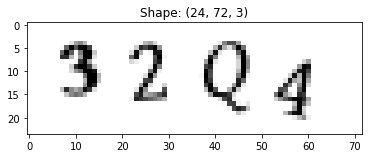

In [63]:
# View an example CAPTCHA

img = cv2.imread('../captcha/'+img_paths[0])
plt.imshow(img)
plt.title(f'Shape: {img.shape}')
plt.show()

In [64]:
# Get list of ground-truth labels from image filenames
labels = [img_path.split('.')[0] for img_path in img_paths]

# Get count of each unique char
char_counts = {}
for label in labels:
    for char in label:
        if char not in char_counts:
            char_counts[char] = 1
        else:
            char_counts[char] += 1
            
# Sort by character
char_counts = sorted(char_counts.items())
# Convert items to two stand-alone lists
chars = [char_count[0] for char_count in char_counts]
counts = [char_count[1] for char_count in char_counts]
# Want first char on top, so reverse order
chars.reverse()
counts.reverse()

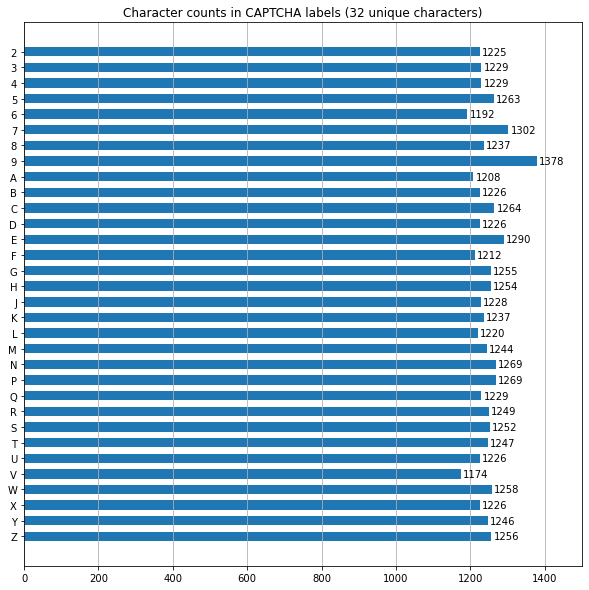

In [65]:
plt.figure(figsize=(10, 10))

bars = plt.barh(y=chars, width=counts, height=0.6)
for bar in bars:
    w = bar.get_width()
    y = bar.get_y()
    h = bar.get_height()
    plt.text(w+40, y+h/2, w, ha='center', va='center')
    
plt.xlim(0, 1500)
plt.grid(linestyle='-', axis='x')
plt.title(f'Character counts in CAPTCHA labels ({len(chars)} unique characters)')
plt.show()

# Character Segmentation

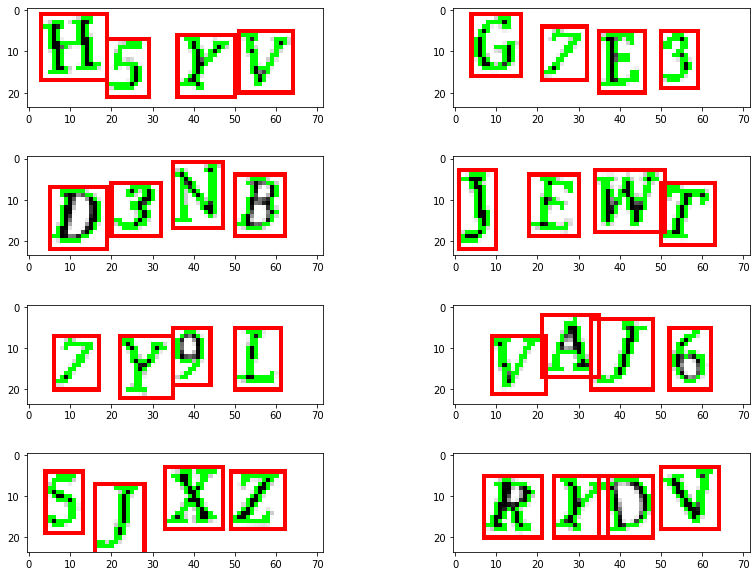

In [66]:
fig = plt.figure(figsize=(14, 10))

plt_rows = 4
plt_cols = 2
plt_iter = 1

plt.subplots_adjust(hspace=0.5)

for i in range(plt_rows*plt_cols):
    plt.subplot(plt_rows, plt_cols, plt_iter)
    
    img_index = np.random.randint(0, len(img_paths))
    # Load random image
    img = cv2.imread('../captcha/'+img_paths[img_index])
    # Covert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take binary threshold
    ret, thresh = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
    # Invert image
    bit_not = cv2.bitwise_not(thresh)
    # Find contours
    contours, hierarchy = cv2.findContours(bit_not, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Draw on orignal image
    cv2.drawContours(img, contours, -1, (0, 255, 0), 1)
    # Get bounding rect of each contour
    rects = [cv2.boundingRect(c) for c in contours]
    # Sort rects by their width
    rects.sort(key=lambda x: x[2])
    
    # Deal with touching letters where one wide bounding box
    # envlopes two letters. split these in half
    while len(rects) < 4:
        # Pop widest rect
        wide_rect = rects.pop()
        x, y, w, h = wide_rect
        # Split in two
        first_half = (x, y, w//2, h)
        second_half = (x+w//2, y, w//2, h)
        rects.append(first_half)
        rects.append(second_half)
        # Re-sort rects by their width
        rects.sort(key=lambda x: x[2])
    
    for rect in rects:
        x, y, w, h = rect
        # Buffer rect by 1 pixel
        cv2.rectangle(img, (x-1, y-1), (x+w+1, y+h+1), (255, 0, 0), 1)
    
    plt.imshow(img)
    plt_iter += 1

This segementation process was written to the [```Segmenter``` class](https://github.com/t-ott/cnn-captcha-solver/blob/master/cnn_captcha_solver/segmenter.py#L5) in the [```cnn_captcha_solver``` package](https://github.com/t-ott/cnn-captcha-solver/tree/master/cnn_captcha_solver).

In [67]:
from cnn_captcha_solver.segmenter import Segmenter

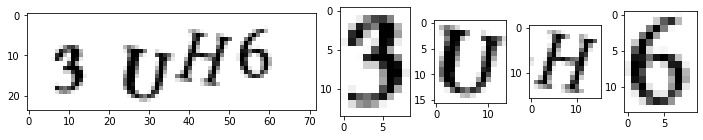

In [68]:
# Demonstrate on random image
img_index = np.random.randint(0, len(img_paths))

Segmenter = Segmenter()
segmented_chars = Segmenter.segment_chars('../captcha/'+img_paths[img_index], plot=True)

# Generate Training Data
Utilizing the [```DataGenerator class```](https://github.com/t-ott/cnn-captcha-solver/blob/master/cnn_captcha_solver/data_generator.py#L9) to extract and save individual character images to a target directory to be used as training data for the CNN model.

In [2]:
from cnn_captcha_solver.data_generator import DataGenerator

In [3]:
DataGenerator = DataGenerator('../captcha')

In [4]:
# Extract training data from training set CAPTCHA images,
# generating ~4*len(test_set) individual character images

DataGenerator.extract_train_set('train')

In [5]:
# Copy the test set CAPTCHA images to test folder, images
# will remain unsegmented until model testing

DataGenerator.save_test_set('test')

In [6]:
# Save a label key file that shows match between CAPTCHA
# characters and their corresponding integer label, e.g.
# '2' = 0, 'G' = 14, 'Q' = 22

DataGenerator.save_label_dict('label_key.csv')

# Prepare PyTorch Dataset and Data Loaders
A custom PyTorch dataset will be defined using the [```CharsDataset class```](https://github.com/t-ott/cnn-captcha-solver/blob/master/cnn_captcha_solver/chars_dataset.py#L8).

In [7]:
from cnn_captcha_solver.chars_dataset import CharsDataset
from torch.utils.data import random_split, DataLoader

In [8]:
CharsDataset = CharsDataset('train_annotations.csv', 'train')

In [9]:
# What is 80% of dataset size?
round(len(CharsDataset)*0.8)

23889

In [10]:
train_set, val_set = random_split(CharsDataset, [24000, len(CharsDataset)-24000])

In [11]:
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=True)

# Train CNN Model
Training a convolutional neural network model built with PyTorch. Architecture is defined in [the ```Model``` class](https://github.com/t-ott/cnn-captcha-solver/blob/master/cnn_captcha_solver/model.py#L6) of the ```cnn_captcha_solver``` package.

In [12]:
from cnn_captcha_solver.model import Model
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable

In [13]:
Model = Model()

In [14]:
val_iter = iter(val_loader)

In [15]:
optimizer = Adam(Model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
epochs = 5

In [16]:
# Training and validation of model

# Will accumulate loss for learning curve plot
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):        
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x (char image)
        b_y = Variable(y)   # batch y (target label, as int)
        output = Model(b_x)
        loss = criterion(output, b_y) 
        train_loss_history.append(loss.data)
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()
        
        # Evaluate on validation set every 50 batches
        if step % 50 == 0:
            val_x, val_y = next(val_iter)
            val_output = Model(val_x)
            val_loss = criterion(val_output, val_y)
            val_loss_history.append(val_loss.data)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| val loss: %.4f' % val_loss.data)

Epoch:  0 | train loss: 3.5189 | val loss: 3.4282
Epoch:  0 | train loss: 2.2873 | val loss: 2.3571
Epoch:  0 | train loss: 1.2076 | val loss: 1.0655
Epoch:  0 | train loss: 0.4550 | val loss: 0.4568
Epoch:  0 | train loss: 0.3059 | val loss: 0.2680
Epoch:  0 | train loss: 0.1764 | val loss: 0.1599
Epoch:  0 | train loss: 0.1241 | val loss: 0.1145
Epoch:  0 | train loss: 0.3337 | val loss: 0.1495
Epoch:  0 | train loss: 0.1815 | val loss: 0.1250
Epoch:  0 | train loss: 0.0729 | val loss: 0.1343
Epoch:  0 | train loss: 0.0628 | val loss: 0.3694
Epoch:  0 | train loss: 0.0619 | val loss: 0.0477
Epoch:  0 | train loss: 0.0269 | val loss: 0.0548
Epoch:  0 | train loss: 0.0231 | val loss: 0.0255
Epoch:  0 | train loss: 0.1548 | val loss: 0.6262
Epoch:  1 | train loss: 0.3545 | val loss: 0.1430
Epoch:  1 | train loss: 0.0119 | val loss: 0.3559
Epoch:  1 | train loss: 0.0793 | val loss: 0.0309
Epoch:  1 | train loss: 0.0869 | val loss: 0.5744
Epoch:  1 | train loss: 0.1788 | val loss: 0.0662


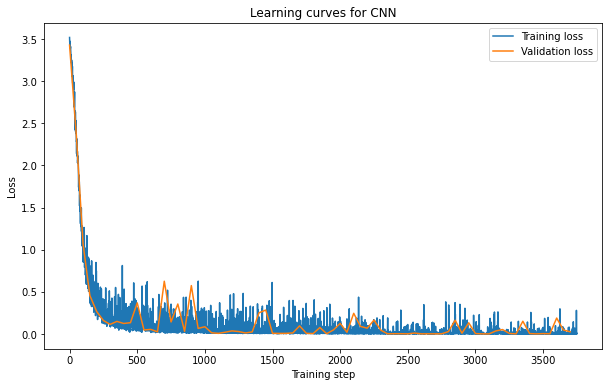

In [17]:
# Plotting learning curve

train_loss_history_x = np.arange(0, len(train_loss_history))

# Only have validation loss every 50 batches
val_loss_history_x = np.arange(0, len(val_loss_history)*50, 50)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history_x, train_loss_history, label='Training loss')
plt.plot(val_loss_history_x, val_loss_history, label='Validation loss')
plt.legend()
plt.title('Learning curves for CNN')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.show()

In [18]:
# Save state dictionary of trained model
torch.save(Model.state_dict(), 'Model4_state_dict.pt')

# Evaluate Model
Evaluate the trained model on the test set using [the ```Evaluator``` class](https://github.com/t-ott/cnn-captcha-solver/blob/master/cnn_captcha_solver/evaluator.py#L11) of the ```cnn_captcha_solver``` package.

In [19]:
from cnn_captcha_solver.evaluator import Evaluator

In [20]:
Evaluator = Evaluator(Model,
                      transform=CharsDataset.transform,
                      label_key='label_key.csv',
                      model_state_dict='Model4_state_dict.pt')

In [21]:
EvaluatorResults = Evaluator.evaluate_test_set('test')

In [22]:
EvaluatorResults.captcha_accuracy

0.9718762555243069

In [23]:
EvaluatorResults.char_accuracy

0.9921655283246283

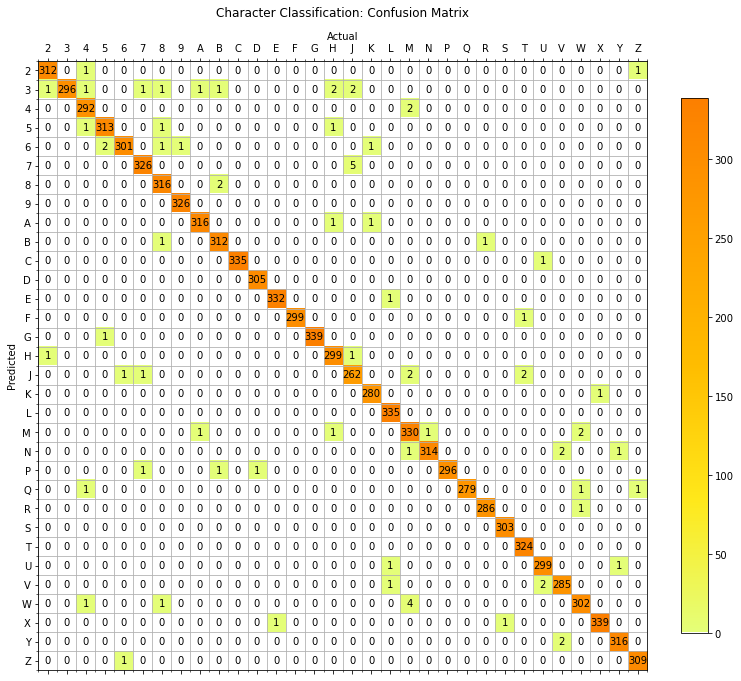

In [24]:
EvaluatorResults.plot_confusion_matrix()

# Potential Improvements

The error rate of the character classification model is 0.783%. In order to correctly solve a given CAPTCHA, every character needs to be correctly classified. If one (out of four) is incorrectly classified, the CAPTCHA prediction will be incorrect. With this current approach, the only way to improve the accuracy of CAPTCHA predictions is to:
1) Improve the character segmentation process to provide cleaner/more reliable training data for the classification model, or
2) Improve the character classification model itself.

Further alterations to the classification model architecture may improve the classification accuracy. No significant hyper-parameter tuning has been performed on the model thus far. Character segmentation improvements would likely be more effective. Dealing with "smushed" pairs of letters is currently done by splitting the pair in half. This does not work very well with letters that have inconsisent widths. For example:

In [60]:
prediction = Evaluator.predict('test/L4MJ.png', print_results=True, plot_segmentation=True)

NameError: name 'Evaluator' is not defined

Another problem with this system is it only manages CAPTCHA text that is four characters in length. It could not manage variable length CAPTCHA text. 